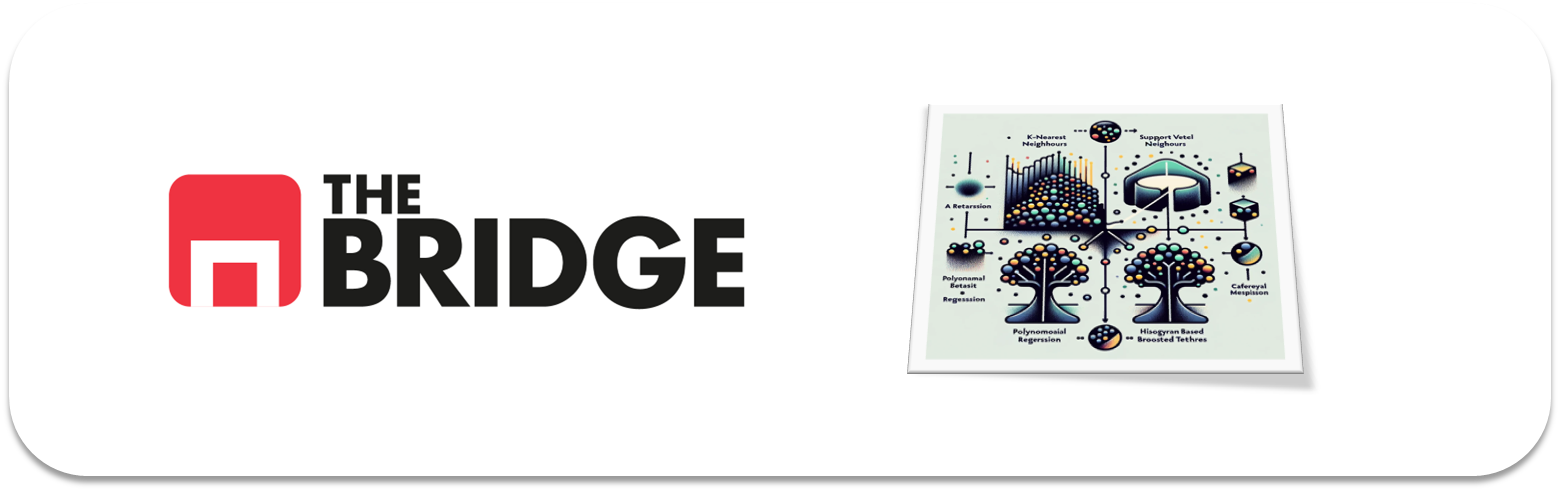

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import bootcampviztools as viz
import ToolBox as tb

from sklearn.metrics import classification_report, root_mean_squared_error, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import classification_report, root_mean_squared_error, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [64]:
df = pd.read_csv("./data/credit_npo.csv")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [66]:
tb.cardinalidad(df, umbral_categoria= 10)

,nombre_variable,valores_unicos,cardinalidad,tipo_sugerido
0,SeriousDlqin2yrs,2,0.000160,Binaria
1,RevolvingUtilizationOfUnsecuredLines,10764,0.858579,Numerica Discreta
2,age,78,0.006222,Numerica Discreta
3,NumberOfTime30-59DaysPastDueNotWorse,10,0.000798,Numerica Discreta
4,DebtRatio,11547,0.921034,Numerica Discreta
5,MonthlyIncome,4167,0.332376,Numerica Discreta
6,NumberOfOpenCreditLinesAndLoans,43,0.003430,Numerica Discreta
7,NumberOfTimes90DaysLate,13,0.001037,Numerica Discreta
8,NumberRealEstateLoansOrLines,16,0.001276,Numerica Discreta
9,NumberOfTime60-89DaysPastDueNotWorse,8,0.000638,Categórica


|Variable|Descripción|Tipo|Notas|
|-|-|-|-|
|SeriousDlqin2yrs|Impago grave dentro de dos años|Binaria|Será nuestro target|||
|RevolvingUtilizationOfUnsecuredLines|Porcentaje utilizado del crédito concedido|Numérica continua||||
|age|edad|Numeroca discreta||||
|NumberOfTime30-59DaysPastDueNotWorse|Número de veces que se ha retrasado entre 30 y 59 días en el pago, pero no más de eso|Numérica discreta/Categórica||||
|DebtRatio|Ratio entre la deuda y los recursos financieros de una persona|Numérica continua||||
|MonthlyIncome|Ingresos mensuales|Numérica continua||||
|NumberOfOpenCreditLinesAndLoans|Número de líneas de crédito y préstamos abiertos|Numérica discreta||||
|NumberOfTimes90DaysLate|Número de veces que se ha retrasado más de 90 días en el pago|Numérica discreta/Categórica||||
|NumberRealEstateLoansOrLines|Número de líneas de crédito o préstamos inmobiliarios|Numérica discreta/Categórica||||
|NumberOfTime60-89DaysPastDueNotWorse|Número de veces que se ha retrasado entre 60 y 89 días en el pago, pero no más de eso|Numérica discreta/Categórica||||
|NumberOfDependents|Número de personas dependientes|Numérica discreta/Categórica||||


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Estamos tratando un problema de clasificación y nuestro target será: SeriousDlqin2yrs

In [67]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

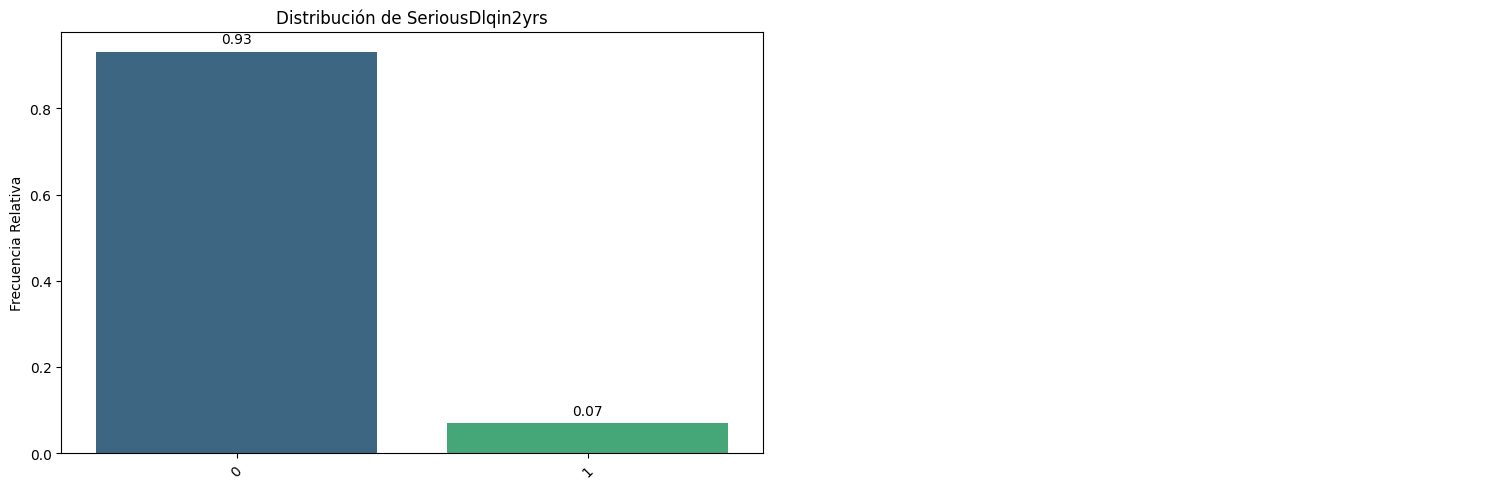

In [68]:
viz.pinta_distribucion_categoricas(df, [target], relativa=True, mostrar_valores=True)

*Es un dataset muy desbalanceado, tendremos que hacer algo para que el modelo funcione mejor*

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

### *Tratamiento de nulos*

*Separamos en train y test*

In [69]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [70]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,10029.000000,10029.000000,10029.000000,10029.00000,10029.000000,9458.000000,10029.000000,10029.000000,10029.000000,10029.000000,9889.000000
mean,0.069897,0.332534,52.006681,0.40014,1.859805,6899.357158,8.480905,0.250972,0.997408,0.221258,0.819395
std,0.254987,0.368161,15.064668,3.96043,9.053464,12785.807976,5.150639,3.940818,1.145652,3.923659,1.134976
min,0.000000,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030773,41.000000,0.00000,0.142648,3481.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.164421,51.000000,0.00000,0.301520,5415.500000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.588571,62.000000,0.00000,0.506312,8290.750000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,5.347652,101.000000,98.00000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


*Imputo nulos*

In [71]:
train.MonthlyIncome = train.MonthlyIncome.fillna(train.describe().loc["50%", "MonthlyIncome"])
test.MonthlyIncome = test.MonthlyIncome.fillna(train.describe().loc["50%", "MonthlyIncome"])

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 5441 to 7270
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      10029 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 2   age                                   10029 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  int64  
 4   DebtRatio                             10029 non-null  float64
 5   MonthlyIncome                         10029 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       10029 non-null  int64  
 7   NumberOfTimes90DaysLate               10029 non-null  int64  
 8   NumberRealEstateLoansOrLines          10029 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  int64  
 10  NumberOfDependents                    9889 non-null   float64
dtypes: float64(4), int

*Dependants espero por si la convierto en categórica*

In [73]:
train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

(3, 2)


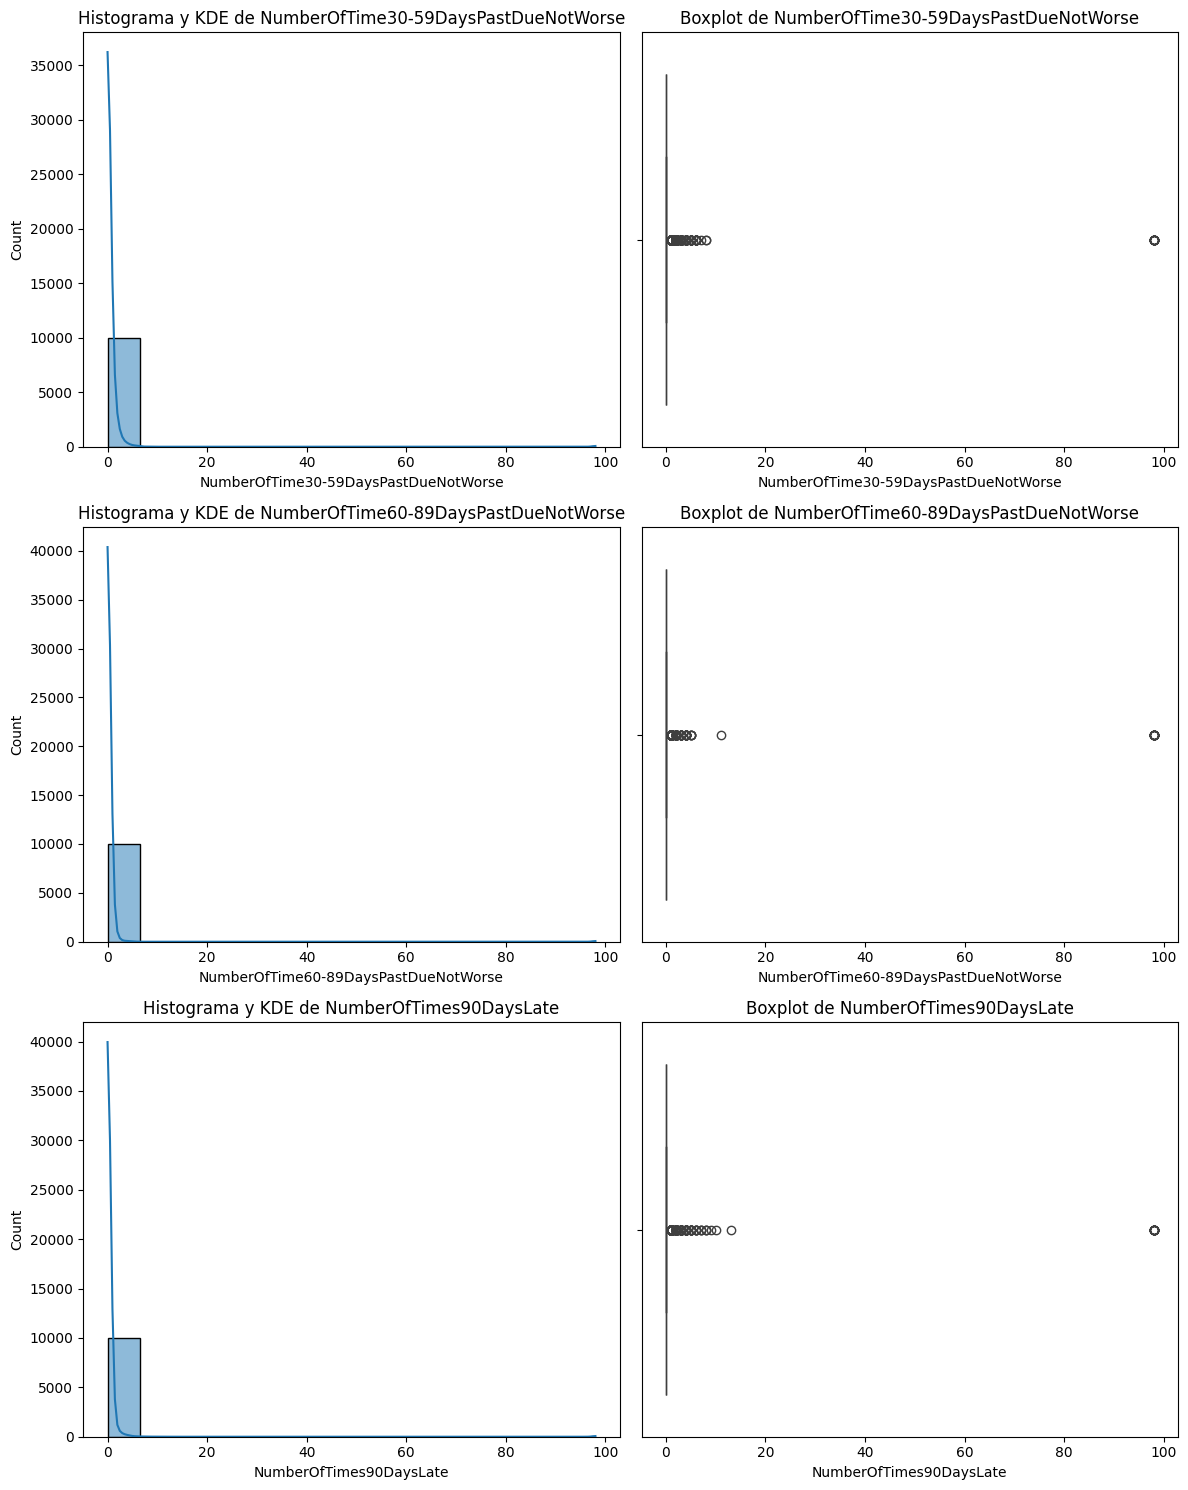

In [74]:
viz.plot_combined_graphs(train, ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"])

*Tienen un valor muy raro de 100 las tres columnas, voy a borrarlos (intuyo que probablemente será el mismo)*

In [75]:
train.loc[train["NumberOfTime30-59DaysPastDueNotWorse"] > 90]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
32,1,1.0,43,98,96.000000,5415.5,0,98,0,98,0.0
4722,1,1.0,51,98,0.000000,7500.0,0,98,0,98,0.0
6188,0,1.0,45,98,0.242193,1440.0,0,98,0,98,0.0
524,0,1.0,29,98,0.000000,5415.5,0,98,0,98,0.0
3803,1,1.0,25,98,0.000000,640.0,0,98,0,98,0.0
1182,0,1.0,25,98,0.020344,1916.0,0,98,0,98,0.0
10995,1,1.0,59,98,0.000000,2180.0,0,98,0,98,0.0
10114,0,1.0,24,98,0.000000,5415.5,0,98,0,98,0.0
9203,0,1.0,22,98,0.000000,4500.0,0,98,0,98,0.0
9047,1,1.0,22,98,0.000000,0.0,0,98,0,98,0.0


*Son varios, parece algún tipo de capado, voy a ver si me quedo con las categóricas, si no lo trataré.*

In [76]:
train["30-59_cat"] = train["NumberOfTime30-59DaysPastDueNotWorse"]> 0
test["30-59_cat"] = test["NumberOfTime30-59DaysPastDueNotWorse"]> 0

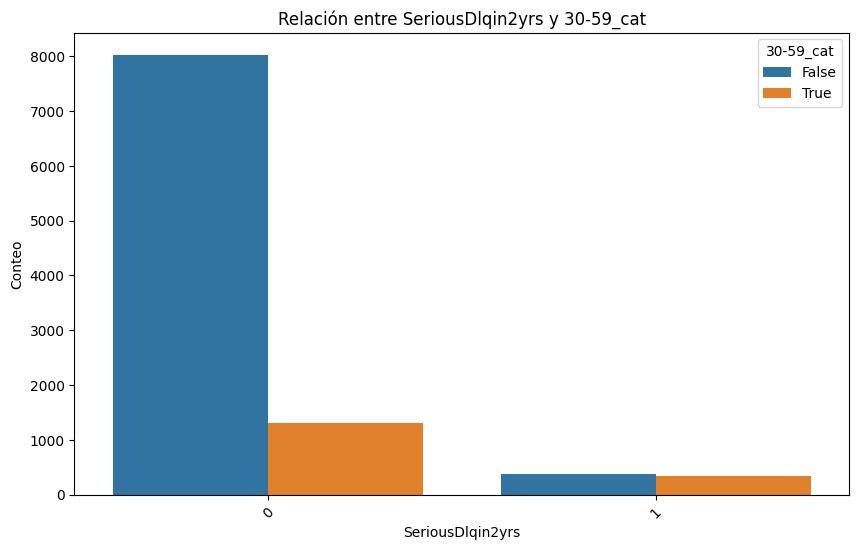

In [77]:
viz.plot_categorical_relationship_fin(train, target, "30-59_cat")

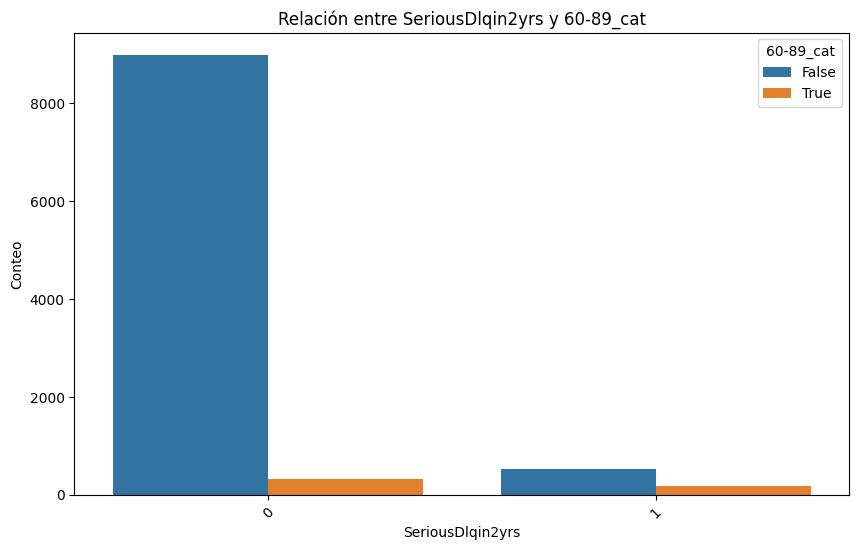

In [78]:
train["60-89_cat"] = train["NumberOfTime60-89DaysPastDueNotWorse"]> 0
test["60-89_cat"] = test["NumberOfTime60-89DaysPastDueNotWorse"]> 0
viz.plot_categorical_relationship_fin(train, target, "60-89_cat")

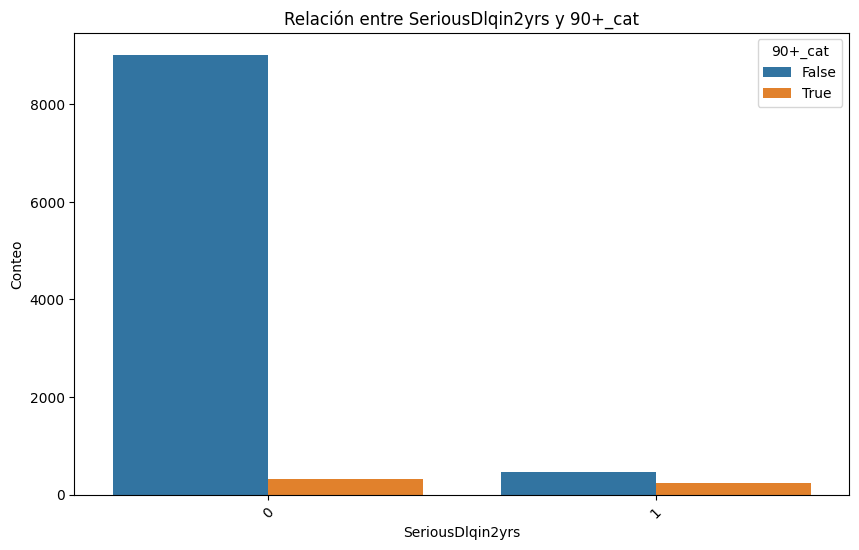

In [79]:
train["90+_cat"] = train["NumberOfTimes90DaysLate"]> 0
test["90+_cat"] = test["NumberOfTimes90DaysLate"]> 0
viz.plot_categorical_relationship_fin(train, target, "90+_cat")

<Axes: xlabel='NumberOfTimes90DaysLate', ylabel='Count'>

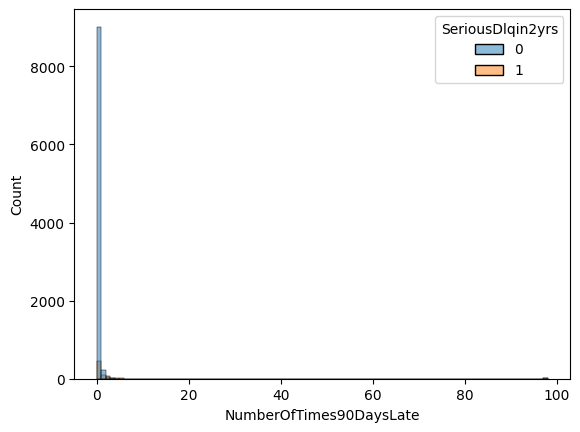

In [80]:
sns.histplot(train, hue = target, x = "NumberOfTimes90DaysLate", bins= 100)

In [81]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,30-59_cat,60-89_cat,90+_cat
5441,0,0.089036,51,0,0.749850,5000.0,6,0,2,0,2.0,False,False,False
3948,0,0.019472,73,0,87.000000,5415.5,12,0,0,0,0.0,False,False,False
8819,0,0.000000,28,1,0.081024,2850.0,4,0,0,0,0.0,True,False,False
315,0,1.000000,40,0,0.956566,5916.0,2,0,2,0,2.0,False,False,False
10746,0,0.409016,61,0,0.427967,16533.0,15,0,3,0,1.0,False,False,False


(2, 2)


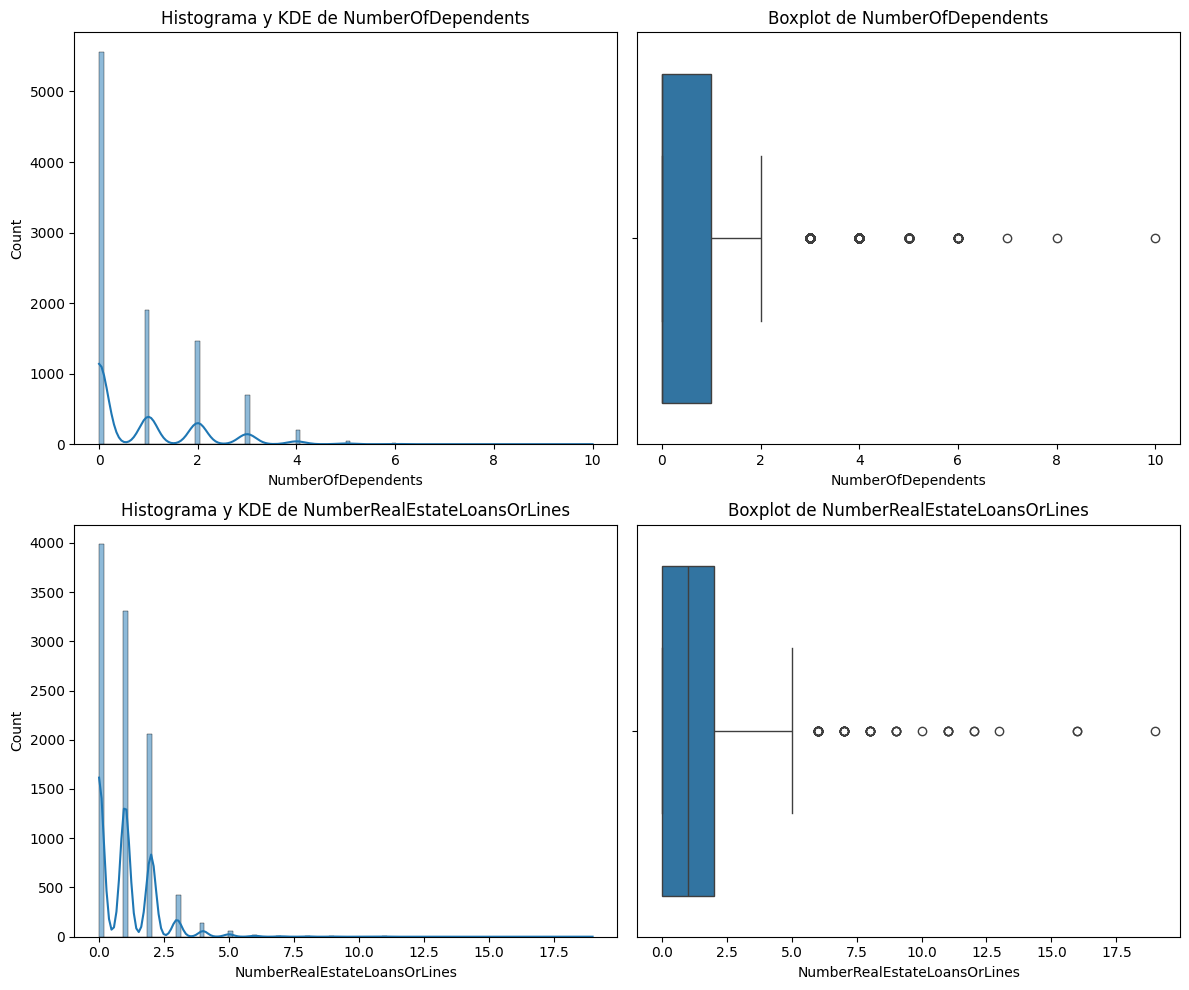

In [82]:
viz.plot_combined_graphs(train, ["NumberOfDependents", "NumberRealEstateLoansOrLines"])

<Axes: xlabel='NumberOfDependents', ylabel='Count'>

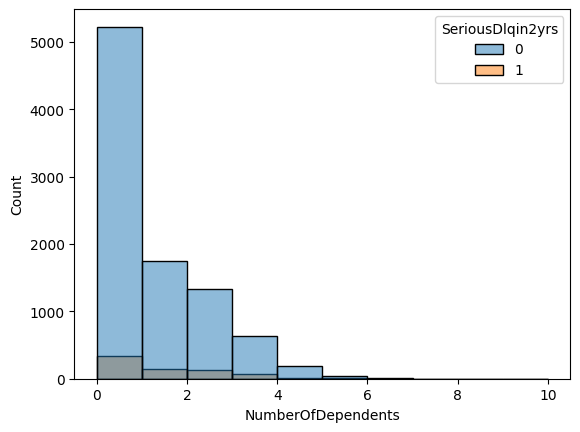

In [83]:
sns.histplot(train, hue = target, x = "NumberOfDependents", bins= 10)

<Axes: xlabel='NumberRealEstateLoansOrLines', ylabel='Count'>

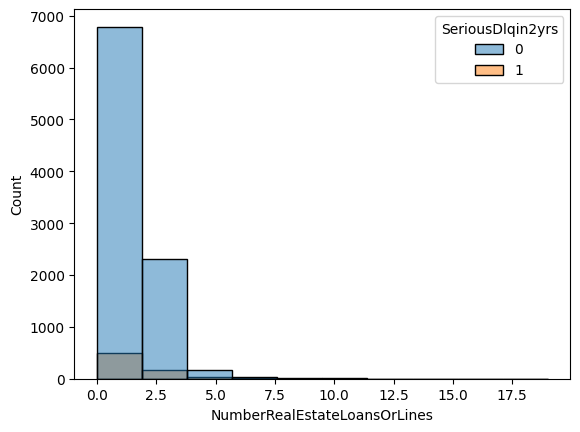

In [84]:
sns.histplot(train, hue = target, x = "NumberRealEstateLoansOrLines", bins= 10)

*Vamos a ver las categóricas*

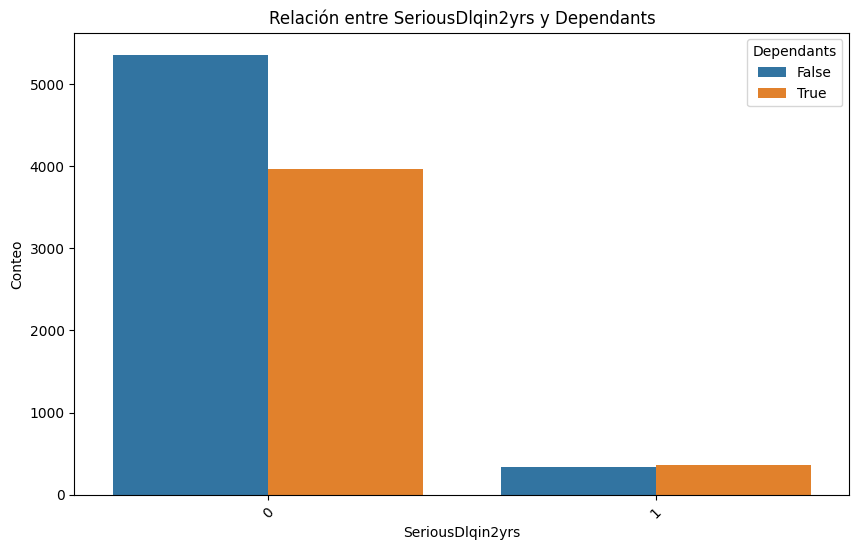

In [85]:
train["Dependants"] = train["NumberOfDependents"]> 0
test["Dependants"] = test["NumberOfDependents"]> 0
viz.plot_categorical_relationship_fin(train, target, "Dependants")

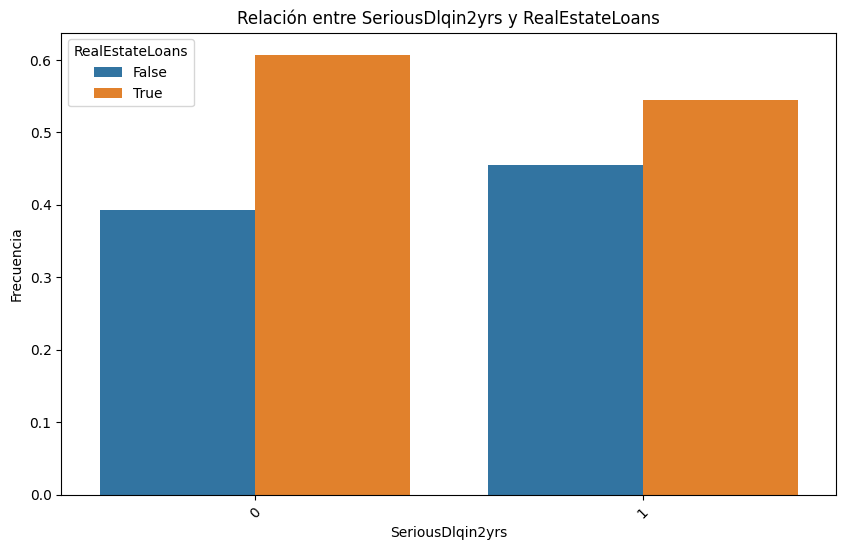

In [86]:
train["RealEstateLoans"] = train["NumberRealEstateLoansOrLines"]> 0
test["RealEstateLoans"] = test["NumberRealEstateLoansOrLines"]> 0
viz.plot_categorical_relationship_fin(train, target, "RealEstateLoans", relative_freq=True)

*En todos los casos me quedo con las categóricas*

In [88]:
train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', '30-59_cat', '60-89_cat', '90+_cat', 'Dependants',
       'RealEstateLoans'],
      dtype='object')

In [90]:
f_cat = train.drop(columns= ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'] + [target]).columns.to_list()
f_num = train.drop(columns= ['NumberOfTime30-59DaysPastDueNotWorse', 
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'] + f_cat + [target]).columns.to_list()

In [91]:
f_cat

['30-59_cat', '60-89_cat', '90+_cat', 'Dependants', 'RealEstateLoans']

array([[<Axes: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'DebtRatio'}>,
        <Axes: title={'center': 'MonthlyIncome'}>]], dtype=object)

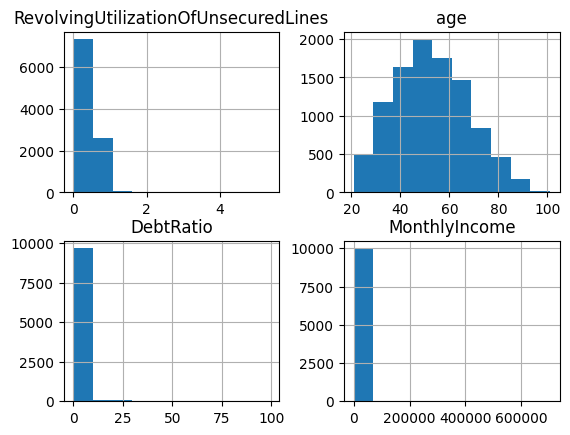

In [103]:
train[f_num].hist()

array([[<Axes: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'DebtRatio'}>,
        <Axes: title={'center': 'MonthlyIncome'}>]], dtype=object)

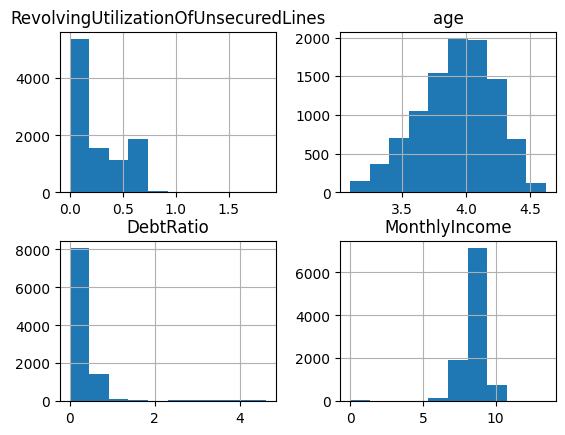

In [102]:
train[f_num].apply(np.log1p).hist()

array([[<Axes: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'DebtRatio'}>,
        <Axes: title={'center': 'MonthlyIncome'}>]], dtype=object)

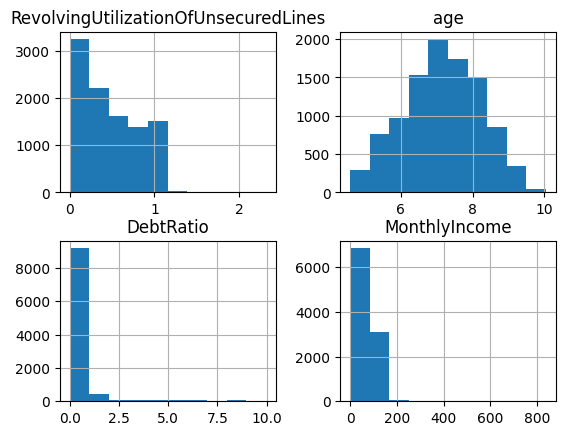

In [101]:
train[f_num].apply(np.sqrt).hist()

(2, 2)


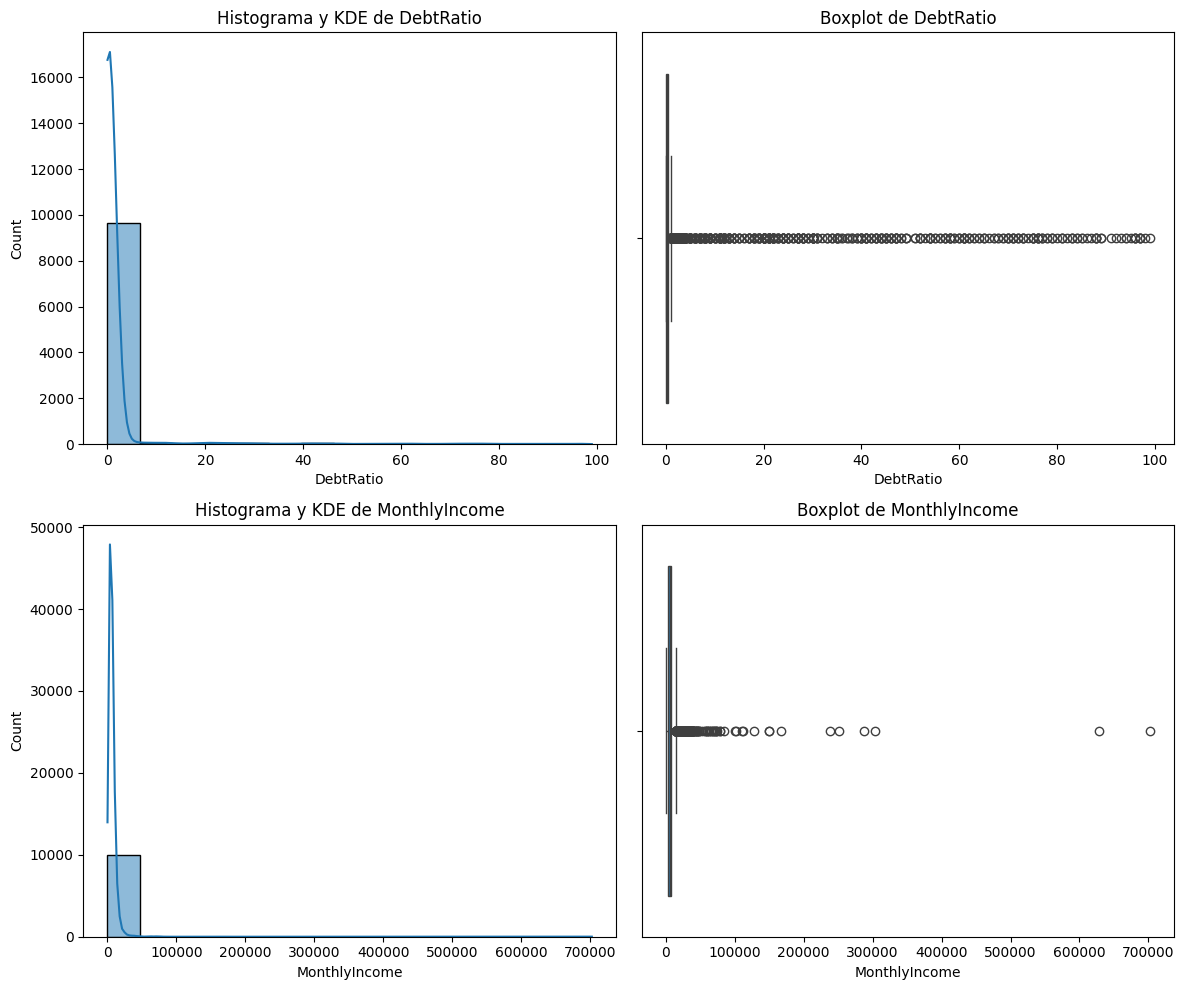

In [94]:
viz.plot_combined_graphs(train, ["DebtRatio", "MonthlyIncome"], bins= 15)

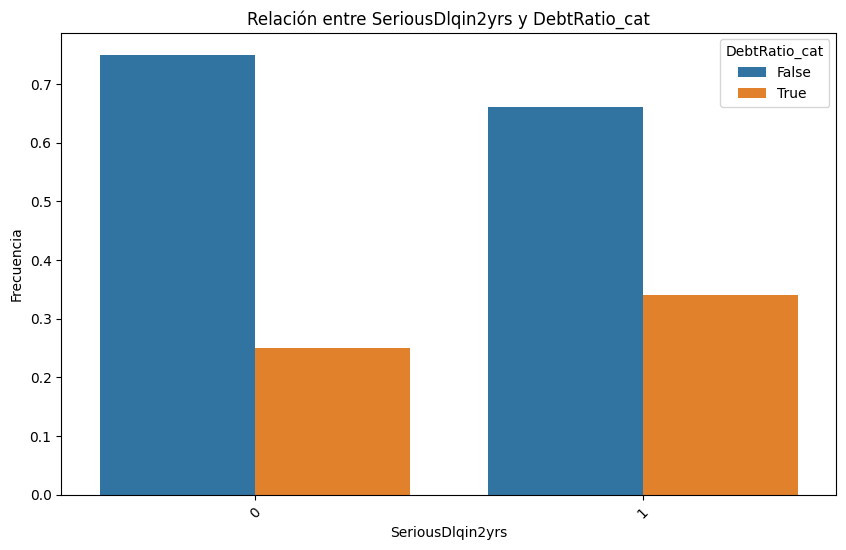

In [100]:
train["DebtRatio_cat"] = train["DebtRatio"]> 0.5
test["DebtRatio_cat"] = test["DebtRatio"]> 0.5
viz.plot_categorical_relationship_fin(train, target, "DebtRatio_cat", relative_freq=True)

*No parecen muy adecuadas para categóricas. Voy a aplicarles el logaritmo a todas menos a age y las voy a escalar en el dataset que voy a usar para los modelos sensibles a las escalas. De baseline voy a usar un Random Forest para aprovechar y obtener la importancia de las features*

In [105]:
f_num

['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']

In [107]:
train_scaled = train.copy()
test_scaled = test.copy()

In [108]:
train_scaled[['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']] = train_scaled[['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']].apply(np.log1p)
test_scaled[['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']] = test_scaled[['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']].apply(np.log1p)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled[f_num] = scaler.fit_transform(train[f_num])
test_scaled[f_num] = scaler.transform(test_scaled[f_num])


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome
count,10029.000000,10029.000000,10029.000000,10029.000000
mean,0.332534,52.006681,1.859805,6814.873916
std,0.368161,15.064668,9.053464,12421.217919
min,0.000000,21.000000,0.000000,0.000000
25%,0.030773,41.000000,0.142648,3547.000000
50%,0.164421,51.000000,0.301520,5415.500000
75%,0.588571,62.000000,0.506312,8000.000000
max,5.347652,101.000000,99.000000,702500.000000


In [112]:
test_scaled[f_num].describe()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome
count,2508.000000,2508.000000,2508.000000,2508.000000
mean,0.046025,0.392130,0.004368,0.000012
std,0.046340,0.189103,0.007198,0.000001
min,0.000000,0.000000,0.000000,0.000000
25%,0.005541,0.250000,0.001334,0.000012
50%,0.027519,0.387500,0.002670,0.000012
75%,0.082388,0.512500,0.004179,0.000013
max,0.363881,0.925000,0.046105,0.000017


In [113]:
features = f_num + f_cat

In [114]:
X_train = train[features].copy()
X_train_scaled = train_scaled[features].copy()
y_train = train[target].copy()

X_test = test[features].copy()
X_test_scaled = test_scaled[features].copy()
y_test = test[target].copy()

#### *Baseline: Random Forest*

In [116]:
rfc = RandomForestClassifier(max_depth=5, random_state=42)
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))
print(rfc.feature_importances_)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9328
           1       0.86      0.14      0.24       701

    accuracy                           0.94     10029
   macro avg       0.90      0.57      0.60     10029
weighted avg       0.93      0.94      0.92     10029

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2345
           1       0.56      0.06      0.11       163

    accuracy                           0.94      2508
   macro avg       0.75      0.53      0.54      2508
weighted avg       0.91      0.94      0.91      2508

[0.2833528  0.05920835 0.0525252  0.04440826 0.09554739 0.11440895
 0.33801065 0.00546895 0.00706945]


In [117]:
rfc = RandomForestClassifier(max_depth=5, random_state=42, class_weight= "balanced")
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))
print(rfc.feature_importances_)

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9328
           1       0.22      0.80      0.34       701

    accuracy                           0.78     10029
   macro avg       0.60      0.79      0.61     10029
weighted avg       0.93      0.78      0.83     10029

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      2345
           1       0.18      0.70      0.29       163

    accuracy                           0.78      2508
   macro avg       0.58      0.74      0.58      2508
weighted avg       0.92      0.78      0.83      2508

[0.42279225 0.06884733 0.02908421 0.02893823 0.15454896 0.08990563
 0.19848096 0.00419545 0.00320698]


In [119]:
imp = pd.DataFrame(rfc.feature_importances_, index = rfc.feature_names_in_)
imp

,0
RevolvingUtilizationOfUnsecuredLines,0.422792
age,0.068847
DebtRatio,0.029084
MonthlyIncome,0.028938
30-59_cat,0.154549
60-89_cat,0.089906
90+_cat,0.198481
Dependants,0.004195
RealEstateLoans,0.003207


In [120]:
rfc = RandomForestClassifier(max_depth=5, random_state=42, class_weight= "balanced")
rfc.fit(X_train_scaled, y_train)
pred_train = rfc.predict(X_train_scaled)
pred_test = rfc.predict(X_test_scaled)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))
print(rfc.feature_importances_)

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9328
           1       0.22      0.80      0.34       701

    accuracy                           0.78     10029
   macro avg       0.60      0.79      0.61     10029
weighted avg       0.93      0.78      0.83     10029

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2345
           1       0.21      0.63      0.32       163

    accuracy                           0.82      2508
   macro avg       0.59      0.73      0.61      2508
weighted avg       0.92      0.82      0.86      2508

[0.42279225 0.06884733 0.02908421 0.02893823 0.15454896 0.08990563
 0.19848096 0.00419545 0.00320698]


In [121]:
imp = pd.DataFrame(rfc.feature_importances_, index = rfc.feature_names_in_)
imp

,0
RevolvingUtilizationOfUnsecuredLines,0.422792
age,0.068847
DebtRatio,0.029084
MonthlyIncome,0.028938
30-59_cat,0.154549
60-89_cat,0.089906
90+_cat,0.198481
Dependants,0.004195
RealEstateLoans,0.003207


In [124]:
features_2 = features.copy()
for i in imp.index:
    if imp.loc[i][0] < 0.0099:
        features.remove(i)

features_2

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 '30-59_cat',
 '60-89_cat',
 '90+_cat',
 'Dependants',
 'RealEstateLoans']

In [125]:
features

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 '30-59_cat',
 '60-89_cat',
 '90+_cat']

In [126]:
X_train = train[features].copy()
X_train_scaled = train_scaled[features].copy()
y_train = train[target].copy()

X_test = test[features].copy()
X_test_scaled = test_scaled[features].copy()
y_test = test[target].copy()

In [127]:
nombres_modelos = ["Random Forest", "Gradient Boost Sklearn", "XGBClassifier", "LGBMClassifier", "KNN"]

rfc = RandomForestClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
xgbc = XGBClassifier(random_state = 42)
lgbmc = LGBMClassifier(random_state=42, verbose = -100)
knn = KNeighborsClassifier()

modelos = [rfc, gbc, xgbc, lgbmc, knn]

In [132]:
dict_cv = {}
scores = []

for nombre, modelo in zip(nombres_modelos, modelos):
    if modelo != "KNN":
        cv_score = cross_val_score(modelo, X_train, y_train, cv=7, scoring= "balanced_accuracy")
        dict_cv[nombre] = cv_score
        scores.append(np.mean(cv_score))
    else:
        cv_score = cross_val_score(modelo, X_train_scaled, y_train, cv=7, scoring= "balanced_accuracy")
        dict_cv[nombre] = cv_score
        scores.append(np.mean(cv_score))
ganador = list(dict_cv.keys())[np.argmax(scores)]
ganador_2 = nombres_modelos[np.argmax(scores)]
print(ganador, ganador_2)

Gradient Boost Sklearn Gradient Boost Sklearn


In [133]:
for nombre, puntuacion in dict_cv.items():
    print(f"El recall de la clase positiva para el {nombre} es de {np.mean(puntuacion)}")
print(f"El ganador es {ganador}, con una puntuación de {np.mean(dict_cv[ganador])}")

El recall de la clase positiva para el Random Forest es de 0.5688253125567158
El recall de la clase positiva para el Gradient Boost Sklearn es de 0.5808690558568003
El recall de la clase positiva para el XGBClassifier es de 0.5790108274644384
El recall de la clase positiva para el LGBMClassifier es de 0.5803331673801766
El recall de la clase positiva para el KNN es de 0.4983023249377338
El ganador es Gradient Boost Sklearn, con una puntuación de 0.5808690558568003


*Optimizo tanto el ganador como el KNN*

In [ ]:
param_grid = {
    "max_depth": [3,6,12],
    "learning_rate": [0.1, 0.3, 0.6, 1],
    "min_samples_split": [2, 20, 50, 100],
    "n_estimators": [100, 200, 400]
}

gbs = GradientBoostingClassifier()

clf_1 = RandomizedSearchCV(
    gbs,
    param_distributions=param_grid,
    scoring= "balanced_accuracy",
    cv = 5,
    random_state = 42,
    n_iter = 5
)
clf_1.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.6, 1],
                                        'max_depth': [3, 6, 12],
                                        'min_samples_split': [2, 20, 50, 100],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, scoring='balanced_accuracy')

In [149]:
clf_1.best_params_

{'n_estimators': 100,
 'min_samples_split': 100,
 'max_depth': 3,
 'learning_rate': 1}

In [153]:
clf_1.best_score_

np.float64(0.6544754727240791)

In [154]:
gbc = clf_1.best_estimator_

pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9328
           1       0.47      0.43      0.45       701

    accuracy                           0.93     10029
   macro avg       0.71      0.70      0.70     10029
weighted avg       0.92      0.93      0.92     10029

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2345
           1       0.42      0.42      0.42       163

    accuracy                           0.92      2508
   macro avg       0.69      0.69      0.69      2508
weighted avg       0.92      0.92      0.92      2508



In [ ]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)

In [143]:
param_grid = {
    "n_neighbors": np.arange(1,21),
    "weights": ["uniform", "distance", None]
}


knn = KNeighborsClassifier()

clf = GridSearchCV(
    knn,
    param_grid= param_grid,
    cv = 5,
    scoring= "balanced_accuracy"
)

clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'weights': ['uniform', 'distance', None]},
             scoring='balanced_accuracy')

In [150]:
clf.best_params_

{'n_neighbors': np.int64(1), 'weights': 'uniform'}

In [151]:
clf.best_score_

np.float64(0.5940600763207387)

In [152]:
knn = clf.best_estimator_

pred_train = knn.predict(X_train_scaled)
pred_test = knn.predict(X_test_scaled)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9328
           1       1.00      1.00      1.00       701

    accuracy                           1.00     10029
   macro avg       1.00      1.00      1.00     10029
weighted avg       1.00      1.00      1.00     10029

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2345
           1       0.23      0.18      0.20       163

    accuracy                           0.91      2508
   macro avg       0.59      0.57      0.58      2508
weighted avg       0.90      0.91      0.90      2508



In [ ]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)

In [155]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_scaled_smote, y_train_scaled_smote = smote.fit_resample(X_train_scaled, y_train)

In [157]:
param_grid = {
    "max_depth": [3,6,12],
    "learning_rate": [0.1, 0.3, 0.6, 1],
    "min_samples_split": [2, 20, 50, 100],
    "n_estimators": [100, 200, 400]
}

gbs = GradientBoostingClassifier()

clf_1 = RandomizedSearchCV(
    gbs,
    param_distributions=param_grid,
    scoring= "balanced_accuracy",
    cv = 5,
    random_state = 42,
    n_iter = 5
)
clf_1.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.6, 1],
                                        'max_depth': [3, 6, 12],
                                        'min_samples_split': [2, 20, 50, 100],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, scoring='balanced_accuracy')

In [158]:
gbc = clf_1.best_estimator_

pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9328
           1       0.99      1.00      0.99       701

    accuracy                           1.00     10029
   macro avg       0.99      1.00      1.00     10029
weighted avg       1.00      1.00      1.00     10029

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2345
           1       0.27      0.40      0.32       163

    accuracy                           0.89      2508
   macro avg       0.61      0.66      0.63      2508
weighted avg       0.91      0.89      0.90      2508



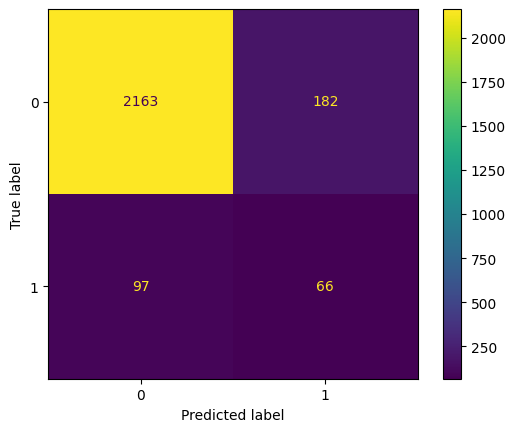

In [159]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)

In [160]:
param_grid = {
    "n_neighbors": np.arange(1,21),
    "weights": ["uniform", "distance", None]
}


knn = KNeighborsClassifier()

clf = GridSearchCV(
    knn,
    param_grid= param_grid,
    cv = 5,
    scoring= "balanced_accuracy"
)

clf.fit(X_train_scaled_smote, y_train_scaled_smote)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'weights': ['uniform', 'distance', None]},
             scoring='balanced_accuracy')

In [161]:
knn = clf.best_estimator_

pred_train = knn.predict(X_train_scaled)
pred_test = knn.predict(X_test_scaled)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9328
           1       1.00      1.00      1.00       701

    accuracy                           1.00     10029
   macro avg       1.00      1.00      1.00     10029
weighted avg       1.00      1.00      1.00     10029

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2345
           1       0.18      0.31      0.23       163

    accuracy                           0.86      2508
   macro avg       0.57      0.61      0.58      2508
weighted avg       0.90      0.86      0.88      2508



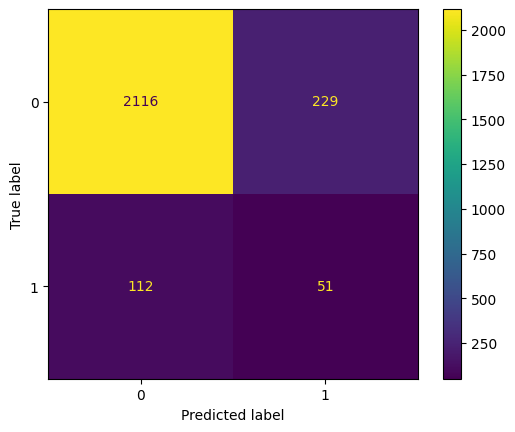

In [162]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)

In [164]:
clase_mayoritaria = X_train[y_train == 0]
clase_minoritaria = X_train[y_train == 1]

clase_mayoritaria_scaled = X_train_scaled[y_train == 0]
clase_minoritaria_scaled = X_train_scaled[y_train == 1]

In [165]:
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples= len(clase_minoritaria),
                                          random_state=42)

In [166]:
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], y_train.loc[clase_minoritaria.index]])

In [ ]:
param_grid = {
    "max_depth": [3,6,12],
    "learning_rate": [0.1, 0.3, 0.6, 1],
    "min_samples_split": [2, 20, 50, 100],
    "n_estimators": [100, 200, 400]
}

gbs = GradientBoostingClassifier()

clf_1 = RandomizedSearchCV(
    gbs,
    param_distributions=param_grid,
    scoring= "balanced_accuracy",
    cv = 5,
    random_state = 42,
    n_iter = 5
)
clf_1.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.6, 1],
                                        'max_depth': [3, 6, 12],
                                        'min_samples_split': [2, 20, 50, 100],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, scoring='balanced_accuracy')

In [ ]:
gbc = clf_1.best_estimator_

pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9328
           1       0.99      1.00      0.99       701

    accuracy                           1.00     10029
   macro avg       0.99      1.00      1.00     10029
weighted avg       1.00      1.00      1.00     10029

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2345
           1       0.27      0.40      0.32       163

    accuracy                           0.89      2508
   macro avg       0.61      0.66      0.63      2508
weighted avg       0.91      0.89      0.90      2508



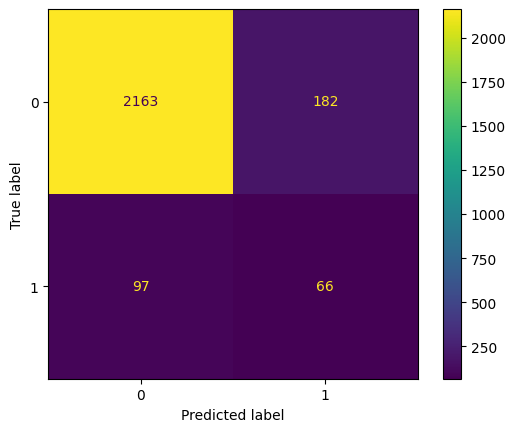

In [ ]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)